In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import xml.etree.ElementTree as xm

from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf

from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Lambda, Input, Reshape
from tensorflow.keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def find_image(im, tpl):
    im = np.atleast_3d(im)
    tpl = np.atleast_3d(tpl)
    H, W, D = im.shape[:3]
    h, w = tpl.shape[:2]

    # Integral image and template sum per channel
    sat = im.cumsum(1).cumsum(0)
    tplsum = np.array([tpl[:, :, i].sum() for i in range(D)])

    # Calculate lookup table for all the possible windows
    iA, iB, iC, iD = sat[:-h, :-w], sat[:-h, w:], sat[h:, :-w], sat[h:, w:] 
    lookup = iD - iB - iC + iA
    # Possible matches
    possible_match = np.where(np.logical_and.reduce([lookup[..., i] == tplsum[i] for i in range(D)]))

    # Find exact match
    for y, x in zip(*possible_match):
        if np.all(im[y+1:y+h+1, x+1:x+w+1] == tpl):
            return (y+1, x+1)

    raise Exception("Brand not found")


In [3]:
shelf_1 = cv2.imread("GroceryDataset/images/ShelfImages/C1_P01_N1_S2_2.JPG")
shelf_2 = cv2.imread("GroceryDataset/images/ShelfImages/C1_P01_N3_S2_1.JPG")

brand = cv2.imread("GroceryDataset/images/BrandImagesFromShelves/1/C1_P01_N3_S2_1.JPG_1556_216_408_700.png")

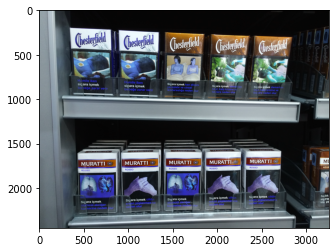

In [4]:
plt.imshow(shelf_1)

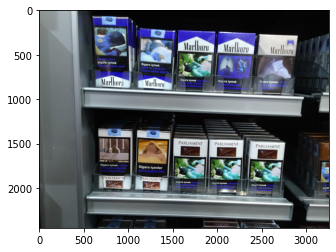

In [5]:
plt.imshow(shelf_2)

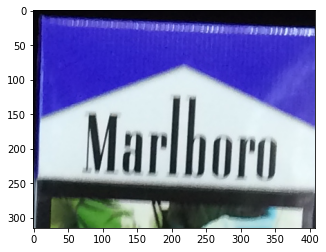

In [6]:
plt.imshow(brand)

In [7]:
cv2.cvtColor(shelf_1, cv2.COLOR_BGR2GRAY)
cv2.cvtColor(shelf_2, cv2.COLOR_BGR2GRAY)
cv2.cvtColor(brand, cv2.COLOR_BGR2GRAY)
shelf_1.shape

(2448, 3264, 3)

In [8]:
brand.shape

(315, 408, 3)

In [9]:
y, x = find_image(shelf_1, brand)

Exception: Brand not found

In [10]:
y, x = find_image(shelf_2, brand)

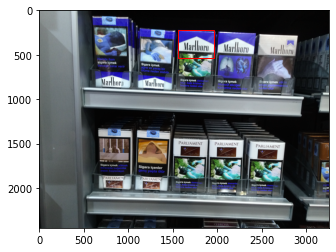

In [13]:
fig, ax = plt.subplots()
plt.imshow(shelf_2)
rect = plt.Rectangle((x, y), brand.shape[1], brand.shape[0], edgecolor='r', facecolor='none')
ax.add_patch(rect)

221


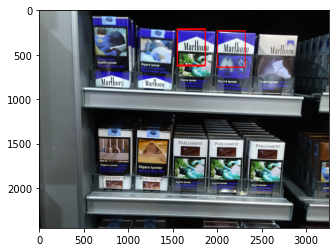

In [35]:
template = cv2.imread("GroceryDataset/images/BrandImagesFromShelves/1/C1_P01_N3_S2_1.JPG_1556_216_408_700.png")
img_rgb = cv2.imread('GroceryDataset/images/ShelfImages/C1_P01_N3_S2_1.JPG')
w, h = template.shape[:-1]

res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)
threshold = .8
loc = np.where(res >= threshold)
print(len(loc[1]))
for pt in zip(*loc[::-1]):  # Switch collumns and rows
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 2)

plt.imshow(img_rgb)

In [36]:
def detect_brand_in_shelf(shelf,brand,dir_name,file_name):
    w, h = brand.shape[:-1]
    res = cv2.matchTemplate(shelf, brand, cv2.TM_CCOEFF_NORMED)
    threshold = .8
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):  # Switch collumns and rows
        cv2.rectangle(shelf, pt, (pt[0] + w, pt[1] + h), (255, 0, 0), 2)
    cv2.imwrite(dir_name + '/' + file_name + str(i) + '.png', shelf)
    
    if len(loc[0]) == 0:
        return False
    else:
        return True